In [1]:
# all_slow
# hide
%load_ext autoreload
%autoreload 2

# Downstream Analysis - Python

Now for the fun bit, wrangling the data and plotting our results! Below, we do this using pandas, matplotlib and statsmodels, and some convenience functions from `clonedetective.clone_analysis`.

## Recap - background and experimental aims

Our original demo dataset consisted of 67 images of the *Drosophila* intestine from a MARCM genetic cell lineage experiment. GFP (C1 channel) marks genetic recombination events, and so clusters of GFP positive cells define "clones" of daughter cells that over time have grown out from a single parent cell. The remaining images include DAPI (C0 channel), which ubiquitously marks all cell nuclei; PDM1 (C2 channel), which labels EnteroCyte (EC) cells; and Prospero (C3 channel), which labels EnteroEndocrine cells.

We aimed to investigate:
1) Does gene of interest regulate **cell proliferation**?  
2) Does our gene of interest control **cell differentiation**?   
3) Does gene of interest effect **local tissue cell arrangement and structure**?

We will tackle each of these experimental aims using data [previously generated by clonedetective](https://morriso1.github.io/clonedetective/Tutorial_Walkthrough.html).

## Loading data and updating column metadata

Reading in our previous results:

In [2]:
import pandas as pd

df = pd.read_csv("data/example_results.csv")

df.head()

,int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,...,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
0,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,2196457.0,True,False,False,False,False
1,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,52757.0,True,False,False,False,False
2,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,2262648.0,True,False,False,False,False
3,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,67331.0,True,False,False,False,False
4,a1g01p1,12,0,4,0,4,1,3,4,0,...,486.798467,0.465227,98.690625,False,4113516.0,True,False,False,False,False


To ease downstream wrangling and plotting, we next update some of the column metadata.

For example, when plotting, it will be helpful to label whether a cell is inside a clone (IC) or outside a clone (OC). This information is already present within the `df['GFP_clonepos']` column that states if a cell is GFP positive. We, therefore, recode this column and rename it to `clone_status`.

In [3]:
import numpy as np

df["GFP_clonepos"] = np.where(df["GFP_clonepos"], "IC", "OC")

In [4]:
df = df.rename(columns={"GFP_clonepos": "clone_status"})
df.head()

,int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,...,centroid-1,eccentricity,area_um2,clone_status,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
0,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,OC,2196457.0,True,False,False,False,False
1,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,OC,52757.0,True,False,False,False,False
2,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,OC,2262648.0,True,False,False,False,False
3,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,OC,67331.0,True,False,False,False,False
4,a1g01p1,12,0,4,0,4,1,3,4,0,...,486.798467,0.465227,98.690625,OC,4113516.0,True,False,False,False,False


We also can extract metadata stored within the image names. We know that images are named 'a1' if from a wild-type (ctrl) animal, and 'a2' if from a mutant (mut) animal. Using this information, we can add an 'genotype' columns.  

In [5]:
df["genotype"] = np.where(df["int_img"].str.match(r"a1"), "ctrl", "mut")

In [6]:
df.head()

,int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,...,eccentricity,area_um2,clone_status,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos,genotype
0,a1g01p1,11,0,2,2,4,1,3,4,0,...,0.440881,73.280625,OC,2196457.0,True,False,False,False,False,ctrl
1,a1g01p1,11,0,2,2,4,1,3,4,0,...,0.440881,73.280625,OC,52757.0,True,False,False,False,False,ctrl
2,a1g01p1,11,0,2,2,4,1,3,4,0,...,0.440881,73.280625,OC,2262648.0,True,False,False,False,False,ctrl
3,a1g01p1,11,0,2,2,4,1,3,4,0,...,0.440881,73.280625,OC,67331.0,True,False,False,False,False,ctrl
4,a1g01p1,12,0,4,0,4,1,3,4,0,...,0.465227,98.690625,OC,4113516.0,True,False,False,False,False,ctrl


## Cell Proliferation - number of cells per clone

Our first aim is to determine whether there is a difference in the number of cells per clone in mutant vs control animals. `count_df` currently contains four rows for each cell - one for each of the four intensity image channels. Since we are presently interested in cell types and numbers, rather than the intensity values of individual cells, we can query count_df for a single intensity image channel. This ensures that `count_data` contains only a single row for each cell.

 For simplicity, we also filter out columns not required for counting the number and type of cells per clone.

In [7]:
count_df = df.query('int_img_ch == "C1"').filter(
    regex=r"clone$|pos$|int_img|clone_status|genotype"
)

To help with later calculations, we add a 'total' column:

In [8]:
count_df["total"] = count_df.filter(regex="_pos").sum(axis=1)

And quickly simplify the cell type column names:

In [9]:
import re

count_df.columns = [re.sub("_pos", "", col) for col in count_df.columns]

Next, we groupby clones per image and sum to get the number of cells of each type per clone.

In [10]:
count_df = count_df.groupby(["int_img", "GFP_clone"], as_index=False).agg(
    {
        "clone_status": "first",
        "genotype": "first",
        "EC": "sum",
        "EE": "sum",
        "preEC": "sum",
        "ECEE": "sum",
        "ISCorEB": "sum",
        "total": "sum",
    }
)
count_df.head()

,int_img,GFP_clone,clone_status,genotype,EC,EE,preEC,ECEE,ISCorEB,total
0,a1g01p1,0,OC,ctrl,70,2,1,4,98,175
1,a1g01p1,1,IC,ctrl,9,0,0,0,5,14
2,a1g01p1,2,IC,ctrl,0,0,0,0,1,1
3,a1g01p1,3,IC,ctrl,1,0,0,0,3,4
4,a1g01p1,4,IC,ctrl,12,0,0,1,21,34


We then groupby only the genotype column and generate a stacked bar plot displaying cell numbers and types per clone. Here, we only interested in plotting cells inside clones, and so we first query on 'clone_status':

In [11]:
count_df_inside = count_df.query('clone_status == "IC"')

inside_clone_mean = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby("genotype")
    .mean()
)

inside_clone_sem = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby("genotype")
    .sem()
)

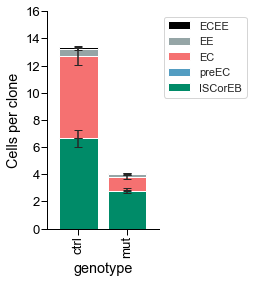

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from clonedetective import clone_analysis as ca

with sns.plotting_context("notebook", font_scale=1.2):
    ca.create_stack_bar_plot(
        inside_clone_mean,
        inside_clone_sem,
        x_figSize=2,
        y_figSize=4,
        color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
        bar_width=0.8,
        y_axis_limit=16,
        y_label="Cells per clone",
    )

From this plot we can see that 'mutant' clones are on average bigger than 'ctrl' clones. This suggests that mutation of our gene of interest may affect **cell proliferation**. Since we have count data, let's fit a negative binomial regression using the statsmodels library test and if this difference is significant:

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import glm

glm_nb = glm(
    "total ~ genotype", data=count_df_inside, family=sm.families.NegativeBinomial()
).fit()

glm_nb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  total   No. Observations:                  429
Model:                            GLM   Df Residuals:                      427
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1297.0
Date:                Tue, 07 Sep 2021   Deviance:                       445.65
Time:                        21:24:55   Pearson chi2:                     577.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.5930      0.074     34.926      0.000       2.447       2.738
genotype[T.mut]    -1.1887      0.104    -11.420      0.000      -1.393      -0.985
===================================================================================
"""

In [14]:
glm_nb.t_test_pairwise('genotype').result_frame

,coef,std err,z,P>|z|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
mut-ctrl,-1.188662,0.104089,-11.419623,3.336787e-30,-1.392674,-0.984651,3.336787e-30,True


Yes, the total number of cells per clone is significantly different in "ctrl" vs "mutant" animals.

**Conclusion:**  
These data are consistent with a role for our gene of interest in controlling cell proliferation. **However**, complementary studies are be required to test this hypothesis further and eliminate alternative theories, e.g. does our gene of interest enhance cell death, leading to few cells per clone.

## Cell Differentiation - percentage cell type inside and outside clones

Next, let's investigate whether the types of cells inside and outside clones are different in ctrl and mutant animals. This information will help us determine whether our gene of interest affects **cell differentiation**.

First, since we already know that 'mutant' clones possess fewer cells than 'ctrl' clones, it is helpful to summarise cell types as a percentage.

In [15]:
percentage_df = count_df.eval(
    """EC = EC / total * 100 
    EE = EE / total * 100
    ECEE = ECEE / total * 100 
    preEC = preEC / total * 100 
    ISCorEB = ISCorEB / total * 100"""
)

Next, we plot a stacked barplot as before. However, this time we plot percentage cell types:

In [16]:
percentage_df_mean = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby(["clone_status", "genotype"])
    .mean()
)

percentage_df_sem = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby(["clone_status", "genotype"])
    .sem()
)

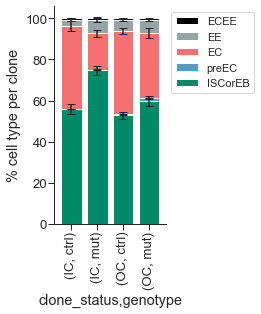

In [17]:
with sns.plotting_context("notebook", font_scale=1.2):
    ca.create_stack_bar_plot(
        percentage_df_mean,
        percentage_df_sem,
        x_figSize=2,
        y_figSize=4,
        color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
        bar_width=0.8,
        y_label="% cell type per clone",
    )

This plot suggests there might be a difference in percentage cell-types of mutant clones vs ctrl. Let's check if these differences are statistically significant.

To do this, we reshape our percentage data into a [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) format:

In [18]:
tidy_percentage_df = pd.melt(
    percentage_df,
    id_vars=["genotype", "clone_status"],
    value_vars=["ISCorEB", "preEC", "EC", "EE", "ECEE"],
    var_name="cell_type",
    value_name="perc_cell_num",
)
tidy_percentage_df.head()

,genotype,clone_status,cell_type,perc_cell_num
0,ctrl,OC,ISCorEB,56.000000
1,ctrl,IC,ISCorEB,35.714286
2,ctrl,IC,ISCorEB,100.000000
3,ctrl,IC,ISCorEB,75.000000
4,ctrl,IC,ISCorEB,61.764706


We then create a composite column that contains genotype (g), clone_status (cs) and cell_type (ct) information.

In [19]:
tidy_percentage_df["g_cs_ct"] = (
    tidy_percentage_df["genotype"]
    + "_"
    + tidy_percentage_df["clone_status"]
    + "_"
    + tidy_percentage_df["cell_type"]
)
tidy_percentage_df.head()

tidy_percentage_df["g_cs_ct"] = tidy_percentage_df["g_cs_ct"].astype("category")

Since we interested in specific comparisons, we setup a contrast matrix.

Our first set of contrasts compares the percentage of each cell type <u>inside mutant vs ctrl clones</u>:

In [20]:
contrasts = [
    "mut_IC_EC-ctrl_IC_EC",
    "mut_IC_EE-ctrl_IC_EE",
    "mut_IC_preEC-ctrl_IC_preEC",
    "mut_IC_ISCorEB-ctrl_IC_ISCorEB",
    "mut_IC_ECEE-ctrl_IC_ECEE",
]

Next, we would like to compare the percentage of each cell type <u>outside mutant vs ctrl clones</u>:

In [21]:
contrasts = contrasts + [
    "mut_OC_EC-ctrl_OC_EC",
    "mut_OC_EE-ctrl_OC_EE",
    "mut_OC_preEC-ctrl_OC_preEC",
    "mut_OC_ISCorEB-ctrl_OC_ISCorEB",
    "mut_OC_ECEE-ctrl_OC_ECEE",
]

Finally, we would  like to compare the percentage of each cell type <u>outside mutant vs inside mutant clones</u>.

In [22]:
contrasts = contrasts + [
    "mut_OC_EC-mut_IC_EC",
    "mut_OC_EE-mut_IC_EE",
    "mut_OC_preEC-mut_IC_preEC",
    "mut_OC_ISCorEB-mut_IC_ISCorEB",
    "mut_OC_ECEE-mut_IC_ECEE",
]

Below is a helper function to construct the values of contrast matrix:

In [23]:
def create_contrast_matrix(desired_contrasts, df_column):
    l = list()
    levels = pd.Series(df_column.cat.categories.values)
    for contrast in desired_contrasts:
        group_A, group_B = contrast.split("-")
        l.append(
            levels.replace({f"^{group_A}$": -1, f"^{group_B}$": 1, ".": 0}, regex=True)
        )
    df = pd.DataFrame(l)
    df.columns = levels.values
    df.index = desired_contrasts
    return df

We can now setup a custom contrast matrix:

In [24]:
matrix = create_contrast_matrix(contrasts, tidy_percentage_df["g_cs_ct"])
matrix

,ctrl_IC_EC,ctrl_IC_ECEE,ctrl_IC_EE,ctrl_IC_ISCorEB,ctrl_IC_preEC,ctrl_OC_EC,ctrl_OC_ECEE,ctrl_OC_EE,ctrl_OC_ISCorEB,ctrl_OC_preEC,mut_IC_EC,mut_IC_ECEE,mut_IC_EE,mut_IC_ISCorEB,mut_IC_preEC,mut_OC_EC,mut_OC_ECEE,mut_OC_EE,mut_OC_ISCorEB,mut_OC_preEC
mut_IC_EC-ctrl_IC_EC,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
mut_IC_EE-ctrl_IC_EE,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0
mut_IC_preEC-ctrl_IC_preEC,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
mut_IC_ISCorEB-ctrl_IC_ISCorEB,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0
mut_IC_ECEE-ctrl_IC_ECEE,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0
mut_OC_EC-ctrl_OC_EC,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0
mut_OC_EE-ctrl_OC_EE,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0
mut_OC_preEC-ctrl_OC_preEC,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1
mut_OC_ISCorEB-ctrl_OC_ISCorEB,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0
mut_OC_ECEE-ctrl_OC_ECEE,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0


Finally, since we have proportional data, we use statsmodels to construct a quasi-binomal regression model and perform tests for our desired contrasts:

In [25]:
# quasi-binomal regression requires the dependent variable be between 0 and 1. Convert percentages to proportions.
tidy_percentage_df["pro_cell_num"] = tidy_percentage_df["perc_cell_num"] / 100

In [26]:
glm_quasi = glm(
    "pro_cell_num ~ g_cs_ct", data=tidy_percentage_df, family=sm.families.Binomial(),
).fit(scale="X2")

t_test_df = glm_quasi.t_test(matrix).summary_frame()
t_test_df.index = matrix.index
t_test_df.round(4)  # round for easier reading

,coef,std err,z,P>|z|,Conf. Int. Low,Conf. Int. Upp.
mut_IC_EC-ctrl_IC_EC,0.7649,0.1978,3.8681,0.0001,0.3773,1.1525
mut_IC_EE-ctrl_IC_EE,-0.8064,0.2862,-2.8173,0.0048,-1.3675,-0.2454
mut_IC_preEC-ctrl_IC_preEC,-1.3296,1.4032,-0.9476,0.3433,-4.0797,1.4205
mut_IC_ISCorEB-ctrl_IC_ISCorEB,-0.8487,0.1217,-6.9731,0.0000,-1.0873,-0.6102
mut_IC_ECEE-ctrl_IC_ECEE,0.0260,0.7414,0.0351,0.9720,-1.4271,1.4792
mut_OC_EC-ctrl_OC_EC,0.3803,0.2990,1.2719,0.2034,-0.2057,0.9663
mut_OC_EE-ctrl_OC_EE,-0.2120,0.6093,-0.3479,0.7279,-1.4062,0.9823
mut_OC_preEC-ctrl_OC_preEC,-1.2323,1.8048,-0.6828,0.4947,-4.7695,2.3050
mut_OC_ISCorEB-ctrl_OC_ISCorEB,-0.2758,0.2887,-0.9552,0.3395,-0.8417,0.2901
mut_OC_ECEE-ctrl_OC_ECEE,0.2190,1.6601,0.1319,0.8950,-3.0346,3.4727


However, as we are performing multiple comparisons, we need to adjust our p values. We can do that using the Benjamini/Hochberg false-discovery rate procedure:

In [27]:
from statsmodels.stats.multitest import fdrcorrection

fdr_results = fdrcorrection(t_test_df["P>|z|"])

t_test_df["pval_fdr_bh"] = fdr_results[1]
t_test_df["reject_fdr_bh"] = fdr_results[0]

t_test_df.round(4)  # round for easier reading

,coef,std err,z,P>|z|,Conf. Int. Low,Conf. Int. Upp.,pval_fdr_bh,reject_fdr_bh
mut_IC_EC-ctrl_IC_EC,0.7649,0.1978,3.8681,0.0001,0.3773,1.1525,0.0008,True
mut_IC_EE-ctrl_IC_EE,-0.8064,0.2862,-2.8173,0.0048,-1.3675,-0.2454,0.0145,True
mut_IC_preEC-ctrl_IC_preEC,-1.3296,1.4032,-0.9476,0.3433,-4.0797,1.4205,0.5722,False
mut_IC_ISCorEB-ctrl_IC_ISCorEB,-0.8487,0.1217,-6.9731,0.0000,-1.0873,-0.6102,0.0000,True
mut_IC_ECEE-ctrl_IC_ECEE,0.0260,0.7414,0.0351,0.9720,-1.4271,1.4792,0.9720,False
mut_OC_EC-ctrl_OC_EC,0.3803,0.2990,1.2719,0.2034,-0.2057,0.9663,0.5085,False
mut_OC_EE-ctrl_OC_EE,-0.2120,0.6093,-0.3479,0.7279,-1.4062,0.9823,0.9720,False
mut_OC_preEC-ctrl_OC_preEC,-1.2323,1.8048,-0.6828,0.4947,-4.7695,2.3050,0.7421,False
mut_OC_ISCorEB-ctrl_OC_ISCorEB,-0.2758,0.2887,-0.9552,0.3395,-0.8417,0.2901,0.5722,False
mut_OC_ECEE-ctrl_OC_ECEE,0.2190,1.6601,0.1319,0.8950,-3.0346,3.4727,0.9720,False


To aid visualization, let's add these results to our stacked percentage barplot from earlier. We annotations only statistically significant comparisons.

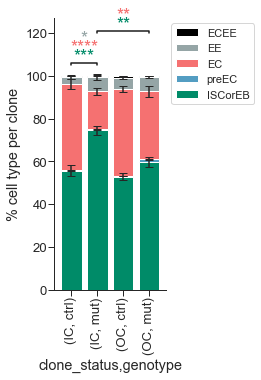

In [28]:
# stat annotation functions from clonedetective:
from clonedetective.clone_analysis import plot_stat_annotation, pvals_to_stat_anots

# convert t_test_results to annotations:
stat_anots = pvals_to_stat_anots(t_test_df["pval_fdr_bh"])

with sns.plotting_context("notebook", font_scale=1.2):
    ca.create_stack_bar_plot(
        percentage_df_mean,
        percentage_df_sem,
        x_figSize=2,
        y_figSize=5,
        color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
        bar_width=0.8,
        y_label="% cell type per clone",
    )
    plot_stat_annotation(
        (0, 1),
        105,
        stat_anots[
            [
                "mut_IC_EC-ctrl_IC_EC",
                "mut_IC_ISCorEB-ctrl_IC_ISCorEB",
                "mut_IC_EE-ctrl_IC_EE",
            ]
        ],
        sep=1,
        text_colors=["#008b68", "#F57171", "#95a5a6"],
    )
    plot_stat_annotation(
        (1, 3),
        120,
        stat_anots[["mut_OC_EC-mut_IC_EC", "mut_OC_ISCorEB-mut_IC_ISCorEB"]],
        sep=1,
        text_colors=["#008b68", "#F57171"],
    )

**Summary of results:**  
* comparing the percentage makeup of control and mutant clones, mutant clones possess significantly fewer ECs and significantly more progenitor cells (e.g. ISCs or EBs) and EEs.
* comparing the percentage makeup of cells inside mutant clones and outside mutant clones, cells inside clones similarly possess significantly fewer ECs and more progenitor cells.
* no significant difference is seen in the percentage makeup of cells outside clones in control vs mutant animals, suggesting our gene of interest may be haploinsufficient.


**Conclusion:**  
Together, these data suggest mutation of our gene of interest may hinder ISC -> EC differentiation. **However**, complementary studies are be required to further test this hypothesis and eliminate alternative theories, e.g. does our gene of interest lead to enhanced EC cell death, resulting in higher percentage progenitor and EE cells.

## Number of neighbours

We have found that mutant clones are smaller than control (wildtype) clones, and may therefore regulate **cell proliferation**. We also found that gene of interest may regulate **cell differentiation**, as mutant clones possess a lower percentage of ECs and a higher percentage of progenitor cells (ISCs or EBs). We now wish to find out whether our gene of interest regulates **local tissue cell arrangement and structure** by comparing the number and type of cell neighbours in control vs mutant clones.

First, we initially perform a 'sanity check' to make sure our 'neighbour counts' are reporting what we would expect.

Since mutant clones are smaller than controls clones, we would expect that compared to cells within control clones, each cell within mutant clones will have (on average) a lower proportion GFP positive neighbours and a higher proportion of GFP negative neighbours.

In [29]:
gfp_df = (
    df.query('int_img_ch == "C0" & clone_status == "IC"')
    .set_index(["int_img", "label", "GFP_clone"])
    .filter(regex="GFP|tot_nc|genotype|clone_status")
    .groupby(["int_img", "GFP_clone"])
    .agg(
        {
            "genotype": "first",
            "GFPneg_nc": "mean",
            "GFPpos_nc": "mean",
            "tot_nc": "mean",
        }
    )
)

In [30]:
tidy_gfp_df = pd.melt(
    gfp_df,
    id_vars=["genotype"],
    value_vars=["GFPneg_nc", "GFPpos_nc", "tot_nc"],
    var_name="neigh_type",
    value_name="neighbour_count",
)

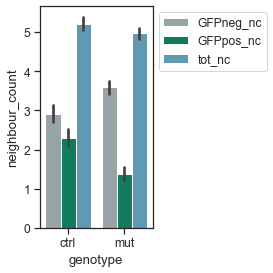

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

with sns.plotting_context("notebook", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.set_style("ticks")
    ax = sns.barplot(
        x="genotype",
        y="neighbour_count",
        hue="neigh_type",
        ax=ax,
        data=tidy_gfp_df,
        palette=["#95a5a6", "#008b68", "#539DC2"],
    )

    # adjust positon of legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")
    plt.tight_layout()

Indeed, mutant clones have, on average, a slightly higher...

In [32]:
# hide
# nc_df = df.query('int_img_ch == "C0"')
# nc_df.set_index(["int_img", "label", "GFP_clone"], inplace=True)
# nc_df = nc_df.filter(regex=r"pos|tot_nc")
# nc_df = nc_df.drop(columns=nc_df.filter(regex=r"GFP"))
# nc_df["cell_type"] = nc_df.filter(regex=r"pos$").idxmax(axis=1)
# nc_df["cell_type"] = nc_df["cell_type"].str.replace("_pos", "")
# nc_df = nc_df.drop(columns=nc_df.filter(regex=r"pos$"))
# nc_df = nc_df.reset_index()
# nc_df["genotype"] = np.where(nc_df["int_img"].str.match(r"a1"), "ctrl", "mut")
# # simplify column names
# nc_df.columns = [re.sub("pos_", "", col) for col in nc_df.columns]
# nc_df["clone_status"] = np.where(nc_df["GFP_clone"] > 0, "ic", "oc")
# nc_df.query('clone_status == "ic"').groupby(["int_img", "GFP_clone"]).sum()

In [33]:
# hide
# tidy_nc_df = pd.melt(
#     nc_df.reset_index(),
#     id_vars=["int_img", "label", "cell_type", "genotype", "GFP_clone"],
#     value_vars=["ECnc", "EEnc", "ECEEnc", "ISCorEBnc", "preECnc"],
#     var_name="neigh_cell_type",
#     value_name="neigh_count",
# )

# major_cell_types = tidy_nc_df.query(
#     'cell_type in ["ISCorEB", "EC", "EE"] and neigh_cell_type in ["ISCorEBnc", "ECnc", "EEnc"]'
# )

# major_cell_types["clone_status"] = np.where(
#     major_cell_types["GFP_clone"] > 0, "ic", "oc"
# )

# major_cell_types["neigh_cell_type"] = pd.Categorical(
#     major_cell_types["neigh_cell_type"]
# )

# import seaborn as sns
# from matplotlib import pyplot as plt

# g = sns.FacetGrid(major_cell_types, col="cell_type", row="clone_status", height=4)
# g.map_dataframe(sns.boxplot, x="neigh_cell_type", y="neigh_count", hue="genotype")
# plt.tight_layout()